In [30]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import sys
import ast
import os

## For plotting
from matplotlib.colors import LogNorm

WORK_DIR = "/home/isaac/TREE-Sims/Bottleneck"
SIMOUT_DIR = os.path.join(WORK_DIR, "2d_sims/")

os.chdir(SIMOUT_DIR)

bot_strengths = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9]
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

for bot in bot_strengths:
    dirs = glob.glob("B-{}*".format(str(bot)))
    print("{} nsims {}".format(bot, len(dirs)))


0.05 nsims 554
0.1 nsims 554
0.25 nsims 554
0.5 nsims 554
0.75 nsims 554
0.9 nsims 554


In [3]:
time_tolerance = 0.03

def fetch_pidxy_simdata(simfiles):
    ## First gather all the data for pi and dxy
    pi_dat = []
    dxy_dat = []
    for f in simfiles:
        lines = open(f).readlines()
        tmp_pi = []
        tmp_dxy = []
        for line in lines:
            try:
                ## Parse each line and get rid of bracket characters
                ldat = line.strip().split()
                l = [float(ldat[0])] + [float(x.translate(None, "[],")) for x in ldat[2:]]
                if "pi" in ldat:
                    tmp_pi.append(l)
                else:
                    tmp_dxy.append(l)
            except Exception as inst:
                print(inst)
        pi_dat.extend(tmp_pi)
        dxy_dat.extend(tmp_dxy)
    print("Processed ntimepoints {} {}".format(len(pi_dat), len(dxy_dat)))
    #print(dxy_dat[:1])

    ## Now go through
    pi_dists = {}
    dxy_dists = {}
    ## Dict for storing distributions per timepoint
    for g, dat in {"pi":pi_dat, "dxy":dxy_dat}.items():
        lambda_dists = {perc:[] for perc in sampling_lambdas}
        ## Ineffecient but i don't care
        for percent in sampling_lambdas:
            tmpdat = []
            for line in dat:
                ## If the difference between the lambda for each line
                ## is close enough to the sampling lambda we want then keep the coltimes
                if abs(line[0] - percent) < time_tolerance:
                    m = np.array(line[2:])
                    p = m[m<0.2]
                    p = p[p>=0]
                    tmpdat.extend(p)
            ## Only sample the first 100000 pi/dxy values
            lambda_dists[percent] = tmpdat[:100000]
        print("Got n datapoints per lambda:")
        for k,v in lambda_dists.items():
            print("{} - {}\t".format(k, len(v))),
        print("\n")
        if "pi" in g:
            pi_dists = lambda_dists
        else:
            dxy_dists = lambda_dists
    return {"pi":pi_dists, "dxy":dxy_dists}

In [14]:
## Fetch all data per invasion time and invasiveness level
## Populate a dict of dicts of dicts
##
## There are many species per timepoint, so there will be many more pi/dxy values in the dict than
## there are timepoints.
pi_dxy_dat = {}
for i in bot_strengths:
    pi_dxy_dat[i] = {}

for i in bot_strengths:
    ## Get the files
    print("Doing {}".format(i))
    simfiles = glob.glob("B-{}*/pidxy.txt".format(i))
    pi_dxy_dat[i] = fetch_pidxy_simdata(simfiles)

Doing 0.05
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert

could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
could not convert string to float: 
Processed ntimepoints 31819 31819
Got n datapoints per lambda:
0.25 - 100000	0.5 - 100000	0.05 - 23866	0.1 - 68590	1 - 100000	0.75 - 100000	

Got n datapoints per lambda:
0.25 - 100000	0.5 - 100000	0.05 - 23866	0.1 - 68590	1 - 100000	0.75 - 100000	

Doing 0.25
Processed ntimepoints 31812 31812
Got n datapoints per lambda:
0.25 - 100000	0.5 - 100000	0.05 - 42785	0.1 - 100000	1 - 100000	0.75 - 100000	

Got n datapoints per lambda:
0.25 - 100000	0.5 - 100000	0.05 - 42785	0.1 - 100000	1 - 100000	0.75 - 100000	

Doing 0.5
Processed ntimepoints 31885 31885
Got n datap

In [16]:
## Does what we got make sense?
print(len(pi_dxy_dat[0.5]["pi"][0.5]))

100000


In [18]:
## Define the function to make the plots. The function takes pi and dxy data per lambda as a dict
def plot_2dSGD_per_lambda(pi_dat, dxy_dat, bot):
    f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300, sharex=True, sharey=True)
    axarr = [a for b in axarr for a in b]
    cmap="jet"
    ## Set min and max range for pi and dxy respectively
    rang=[[0.001, 0.02], [0, 0.06]]
    for i, k, ax in zip(xrange(0,6), sampling_lambdas, axarr):
        ax.set_title(u"Λ = {}".format(k), fontsize=10)
        _, _, _, im = ax.hist2d(pi_dat[k], dxy_dat[k], bins=30, cmap=cmap, norm=LogNorm(), normed=True, range=rang)
    f.text(0.5, 0.01, u"Nucleotide diversity (π)", ha='center', fontsize=13)
    f.text(0.04, 0.5, r"Absolute divergence ($D_{xy}$)", va='center', rotation='vertical', fontsize=13)
    plt.suptitle("2D-SGD Through Time for bottleneck strength {}".format(bot), y=.9999, fontsize=15)
    plt.subplots_adjust(hspace=.25)

    cb_ax = f.add_axes([0.93, 0.12, 0.015, 0.76])
    cbar = f.colorbar(im, cax=cb_ax)


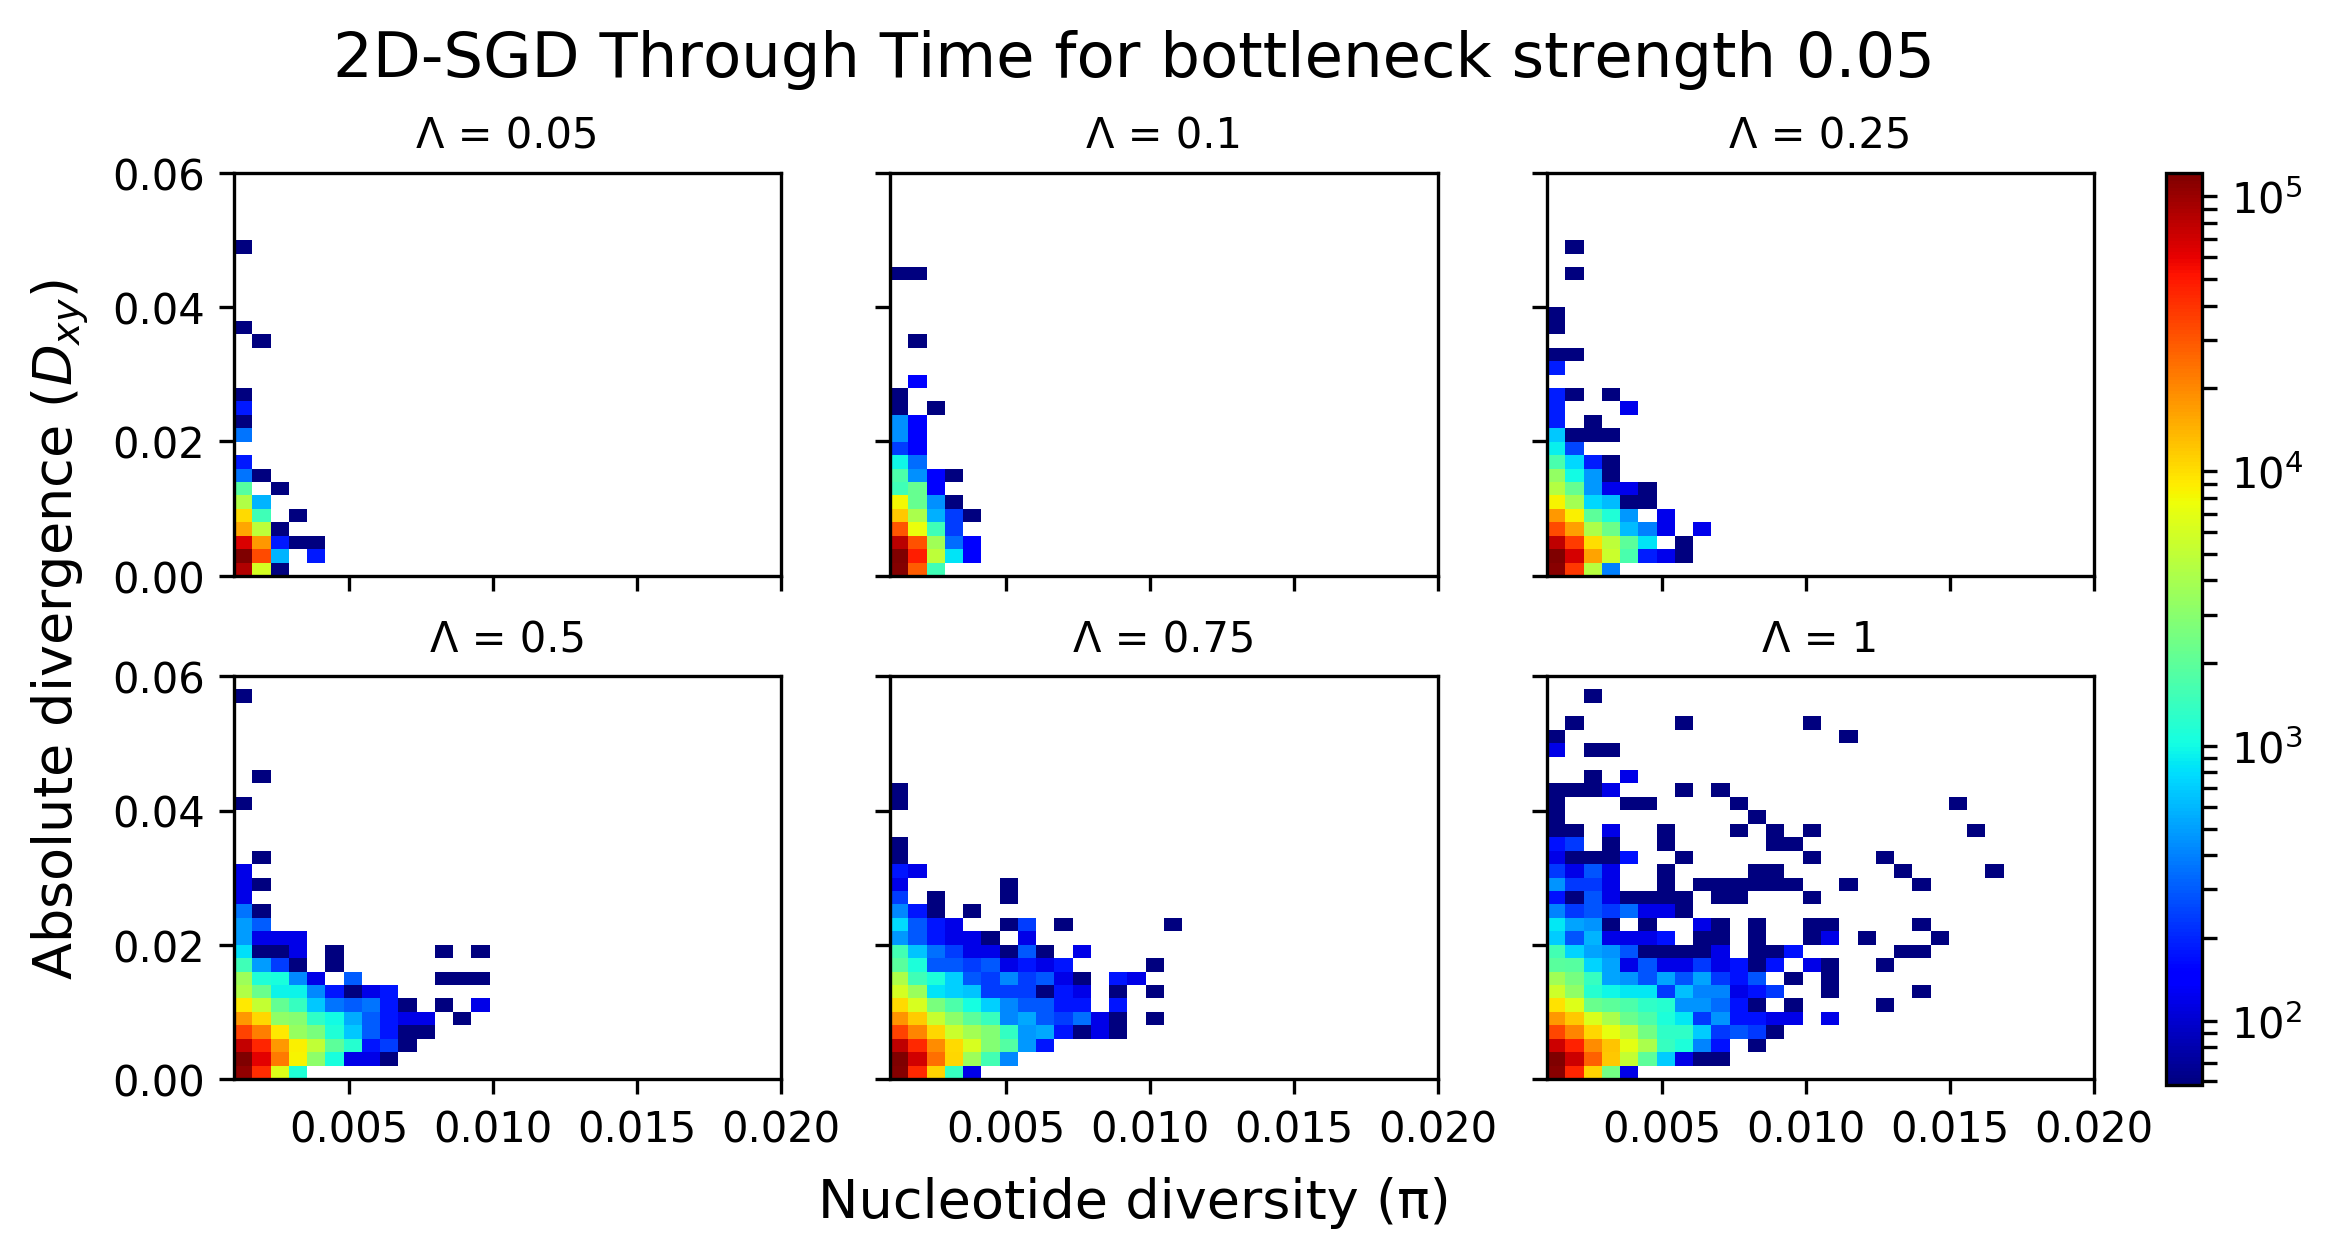

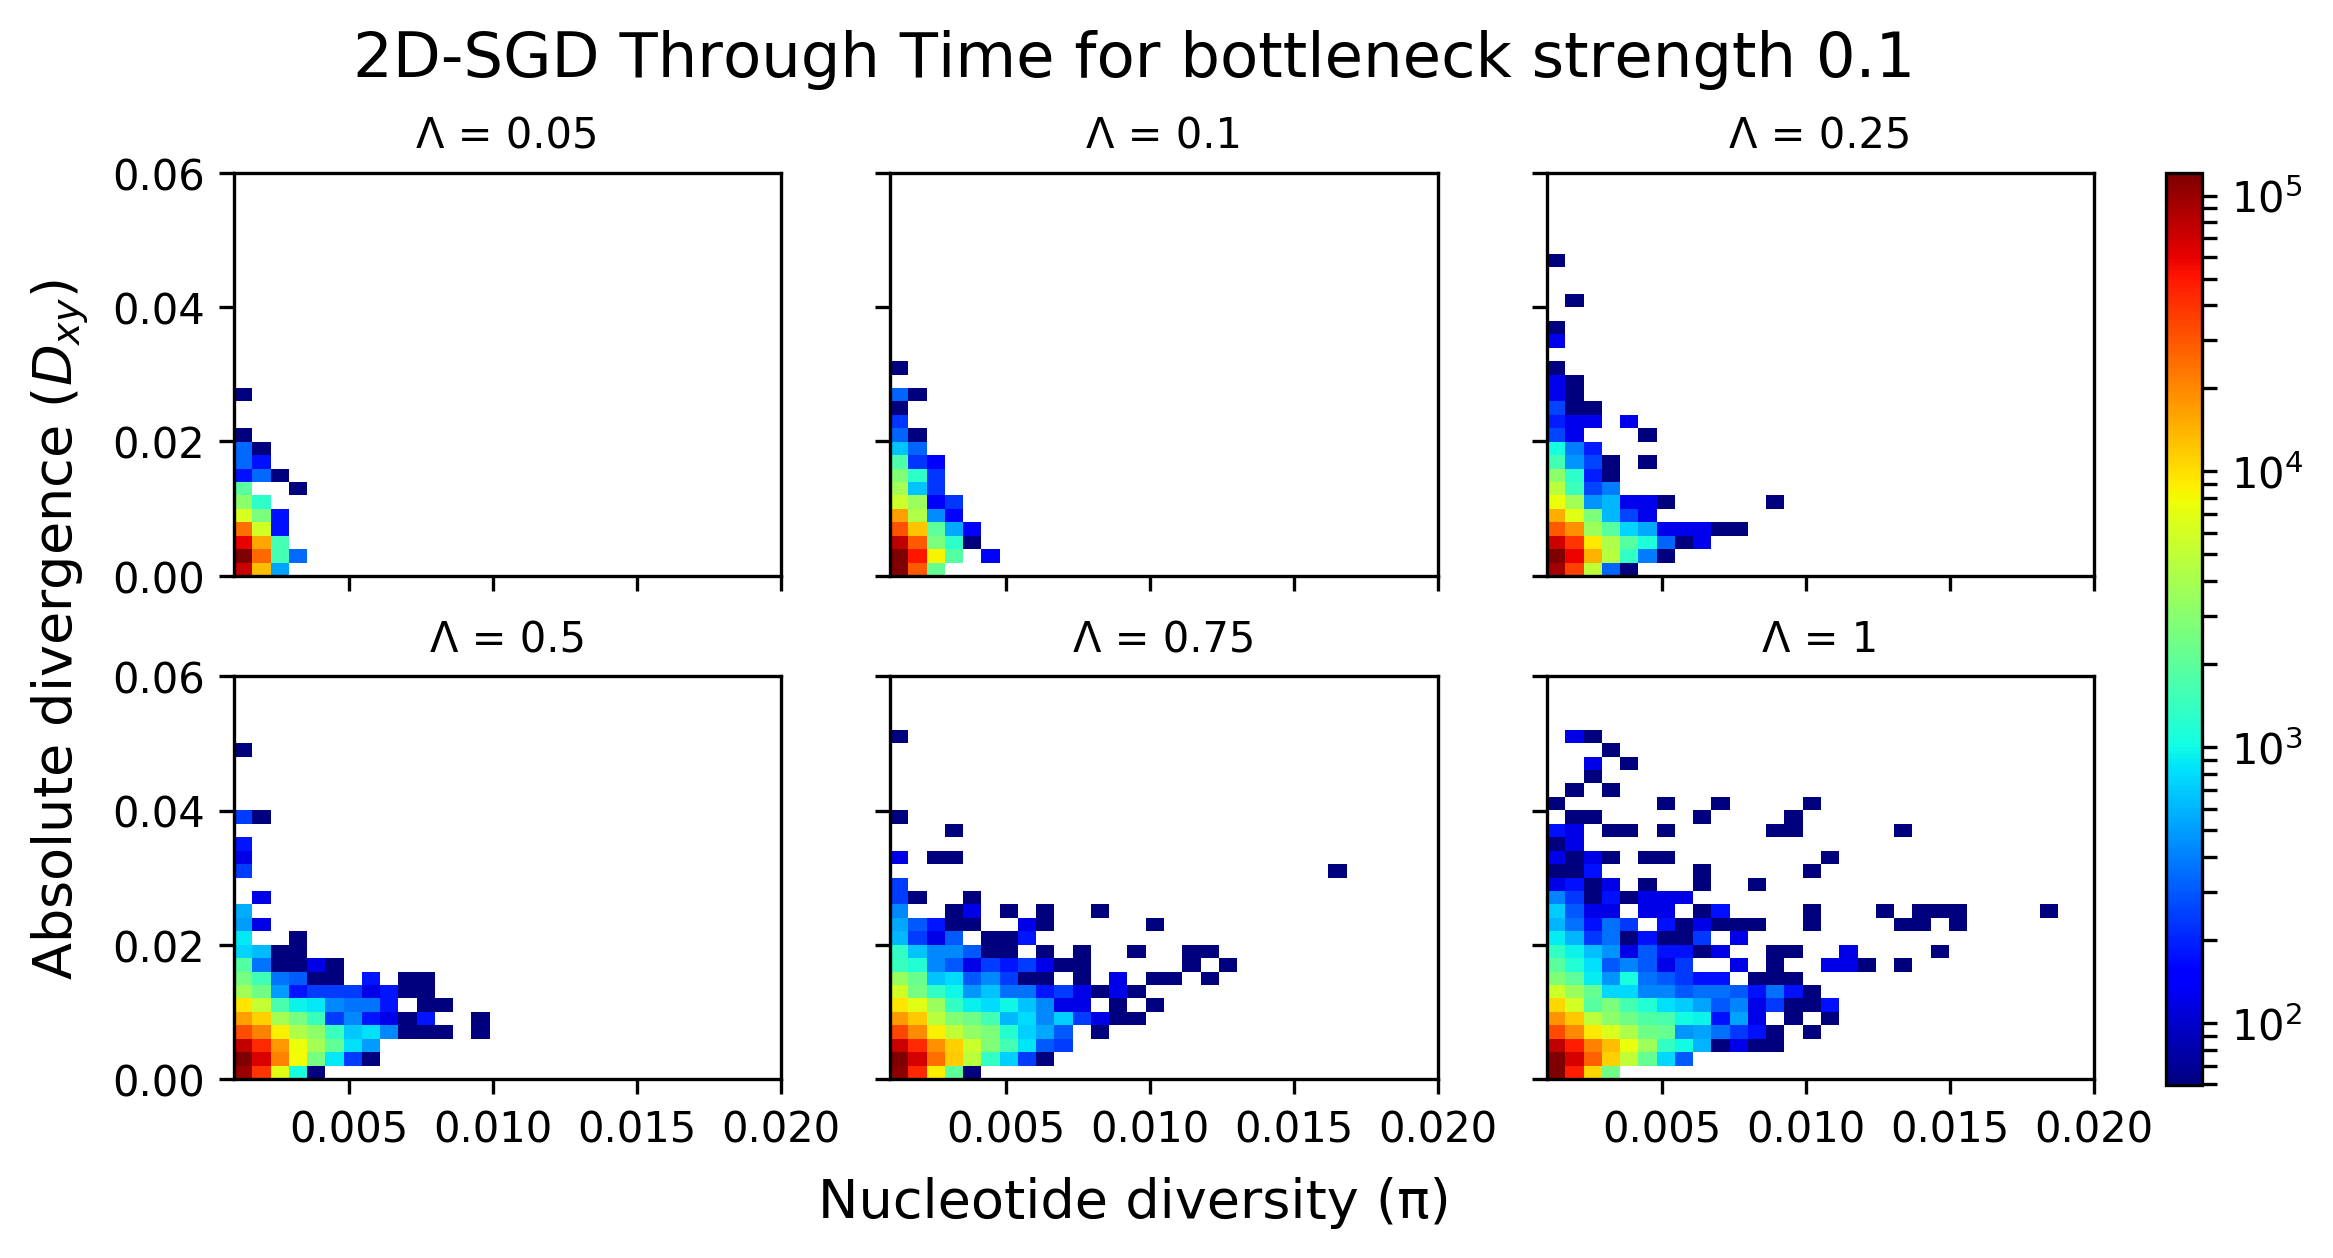

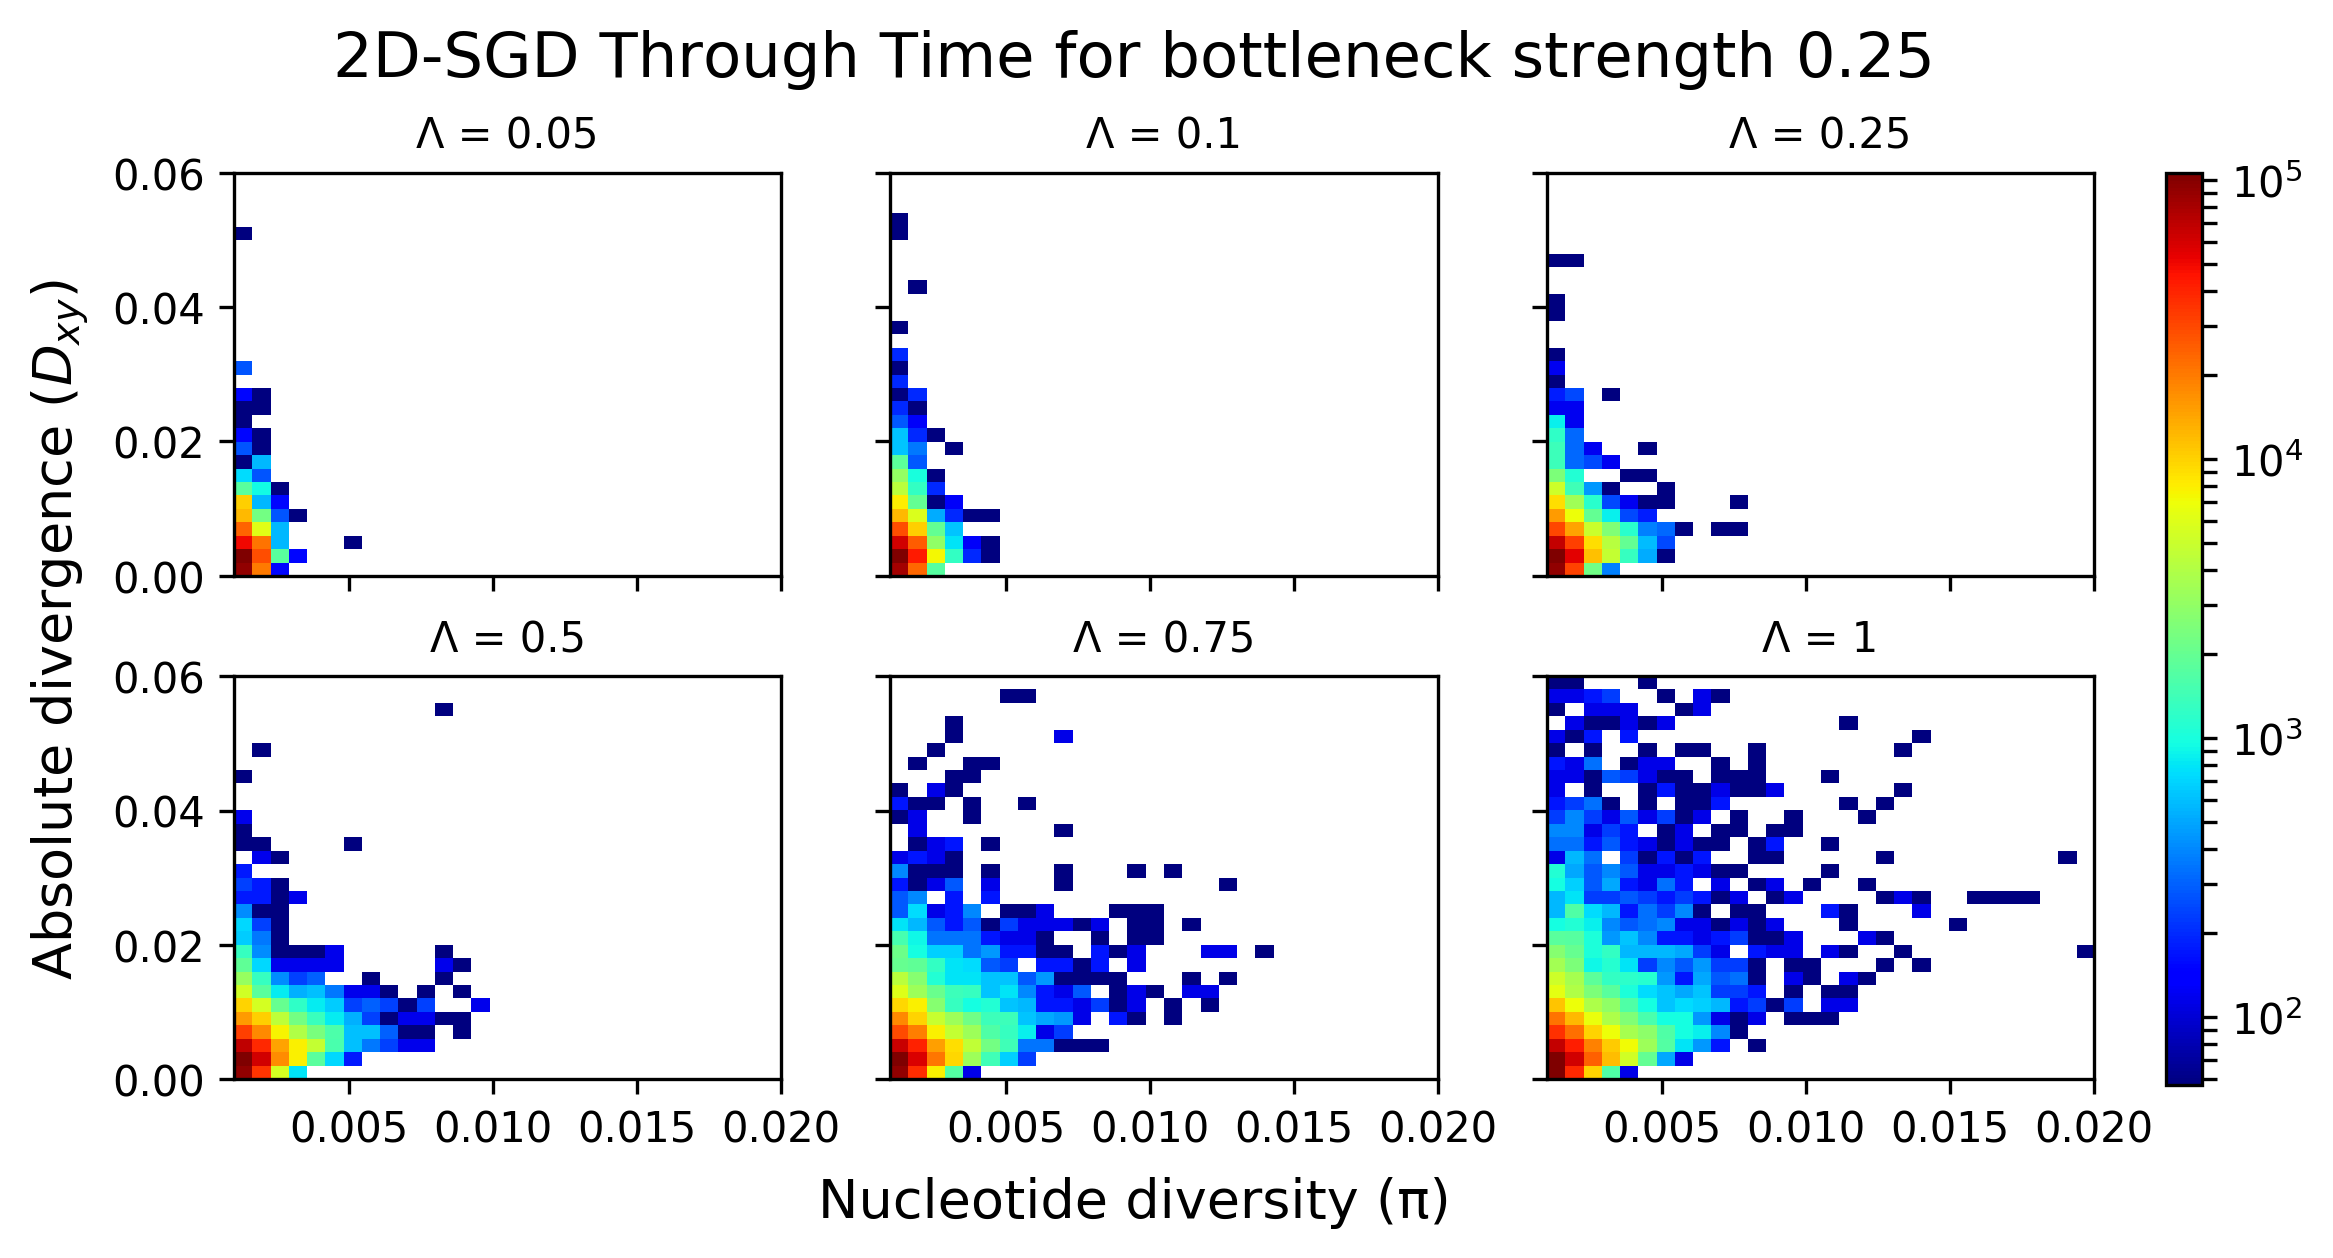

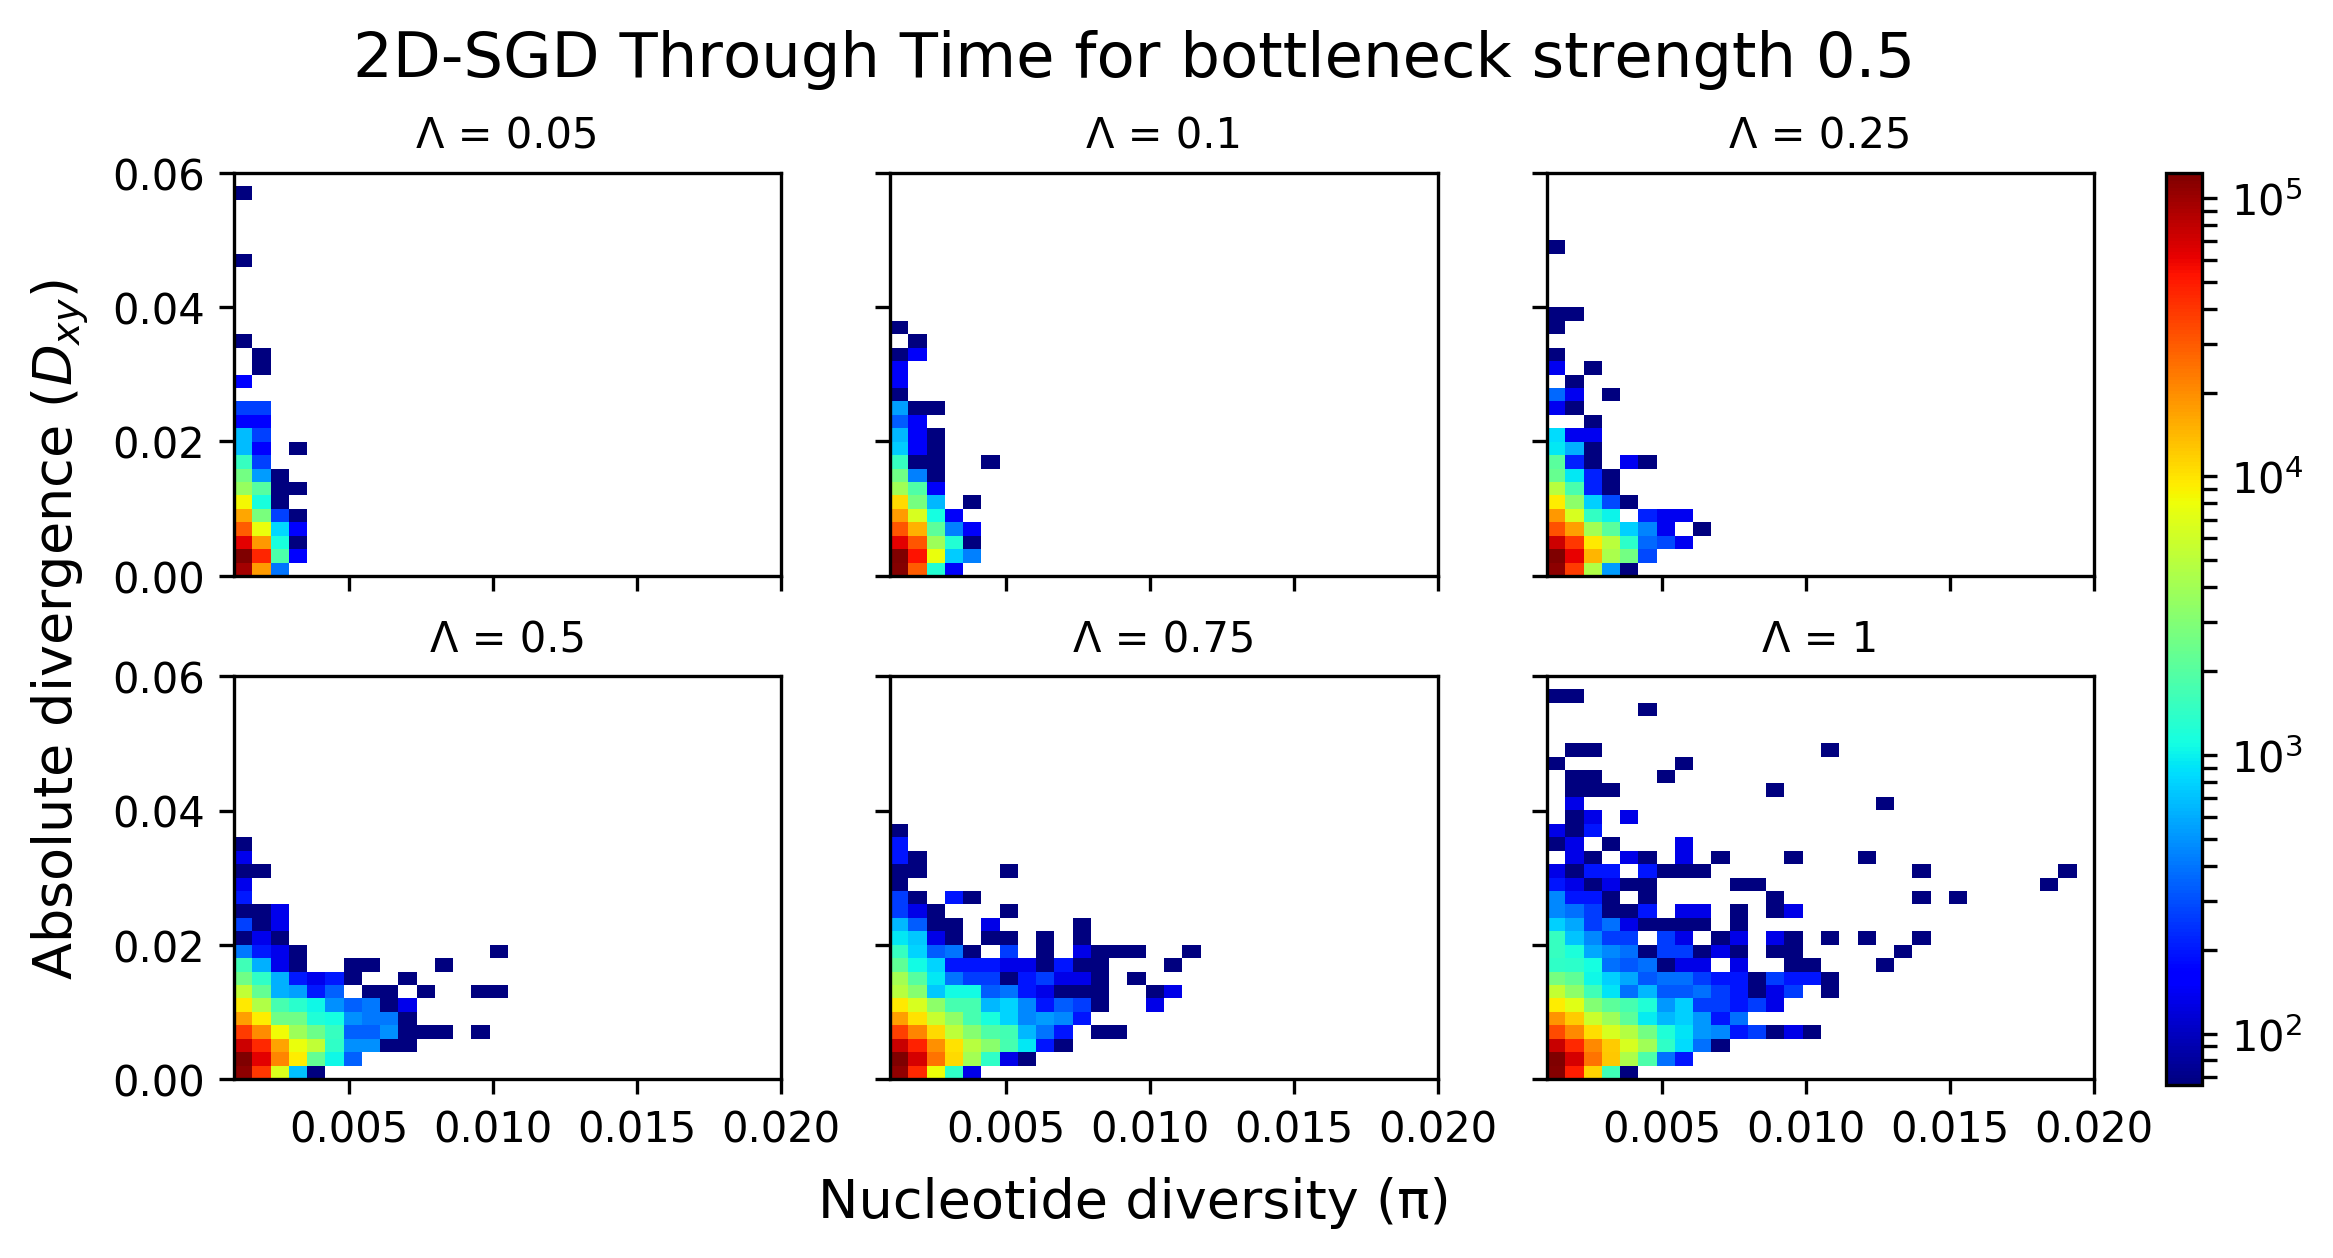

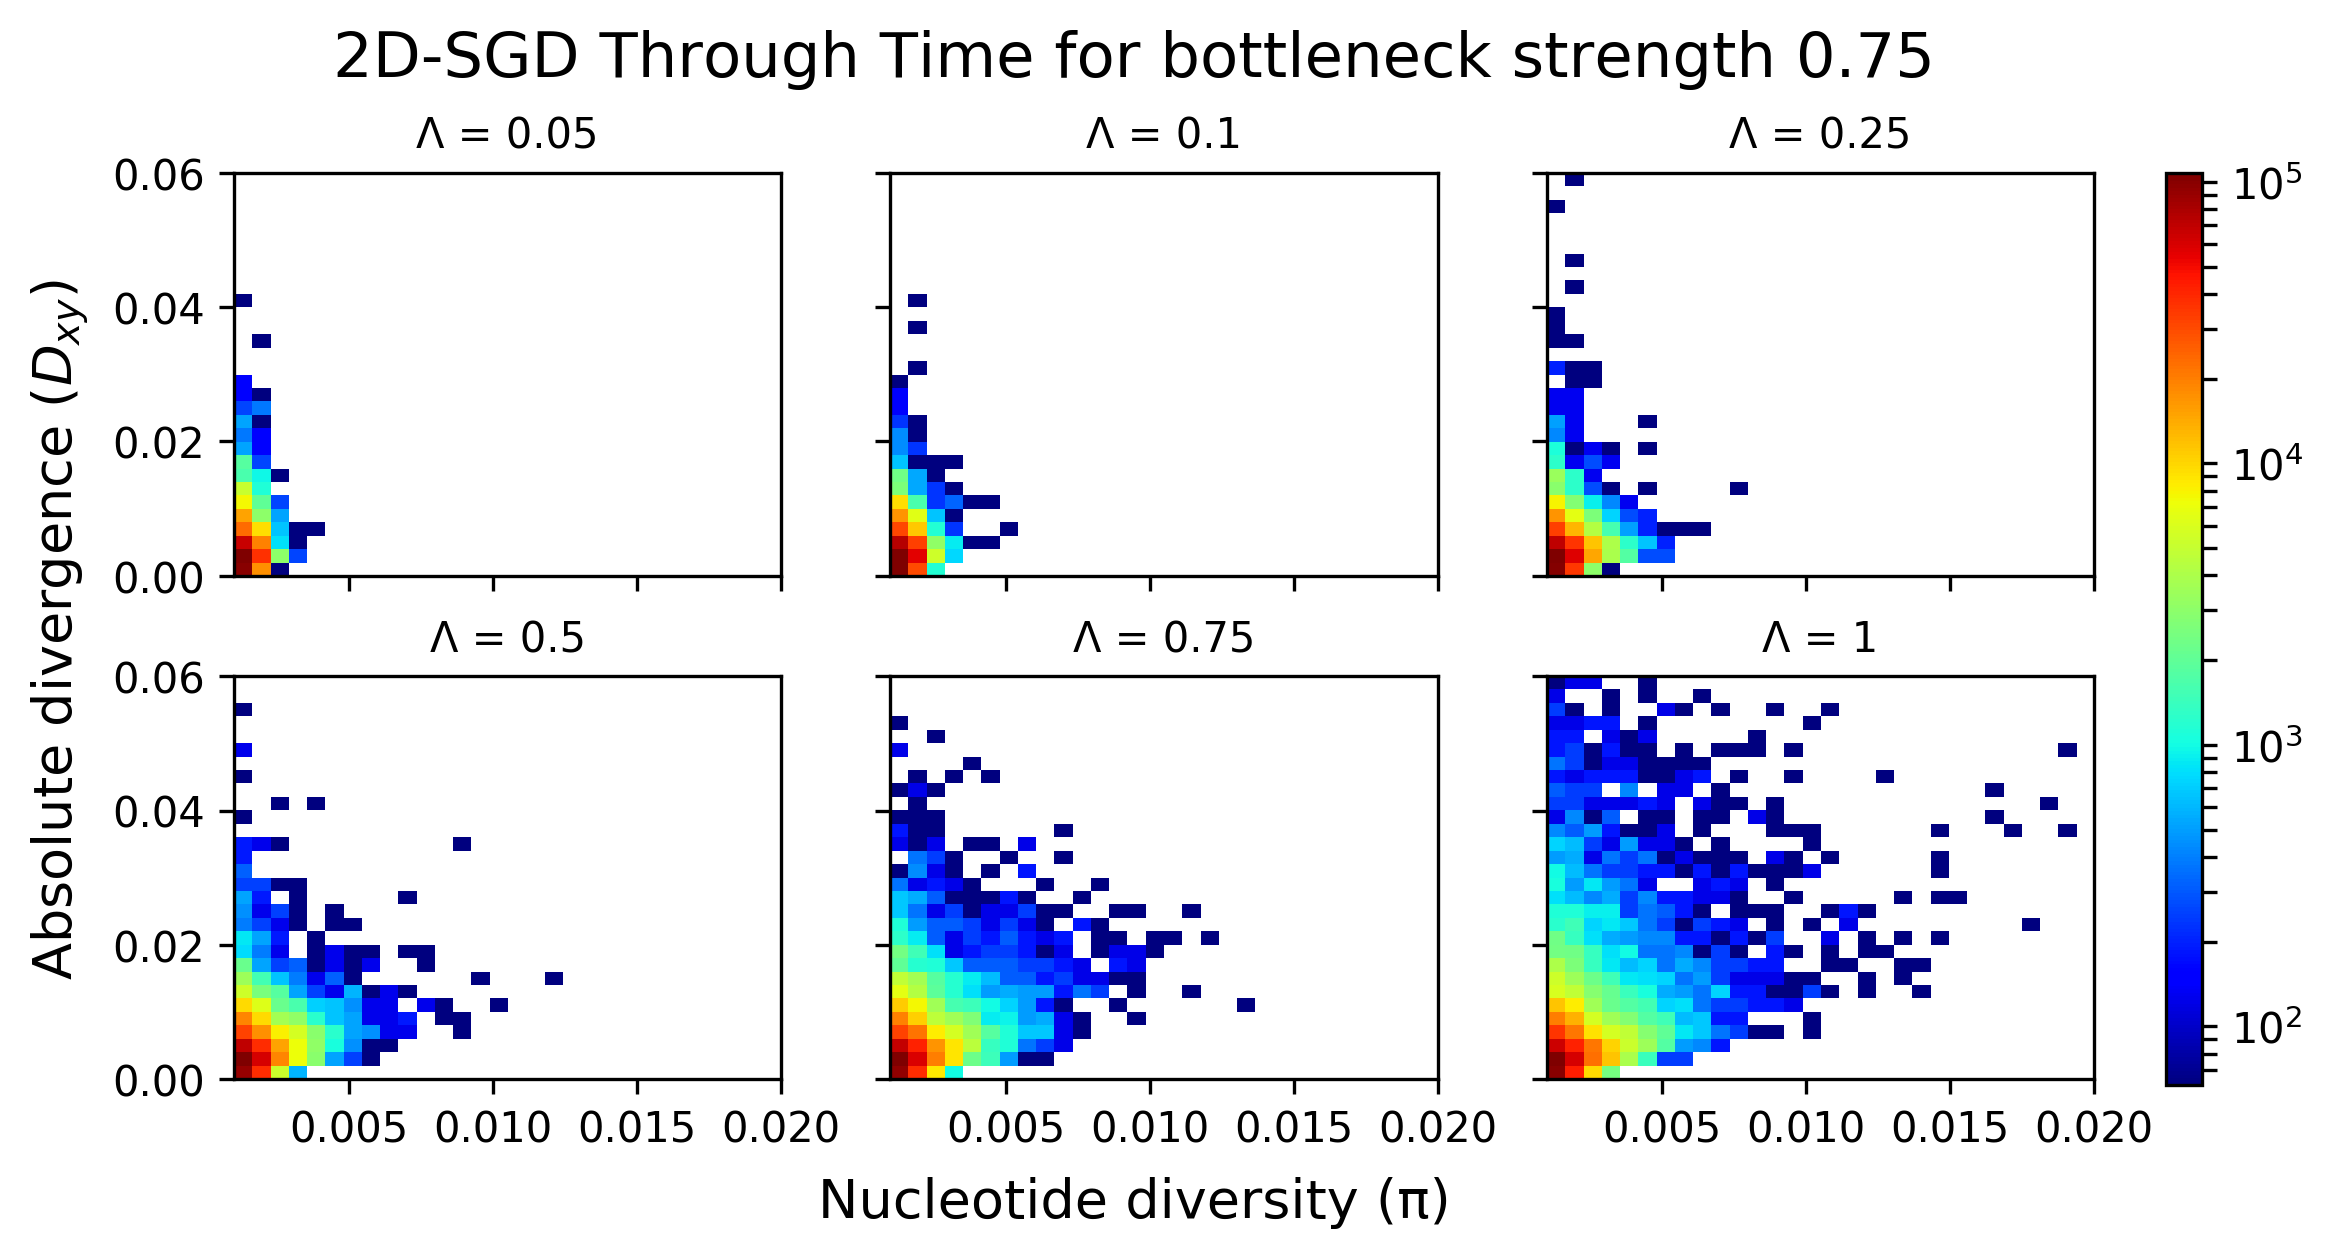

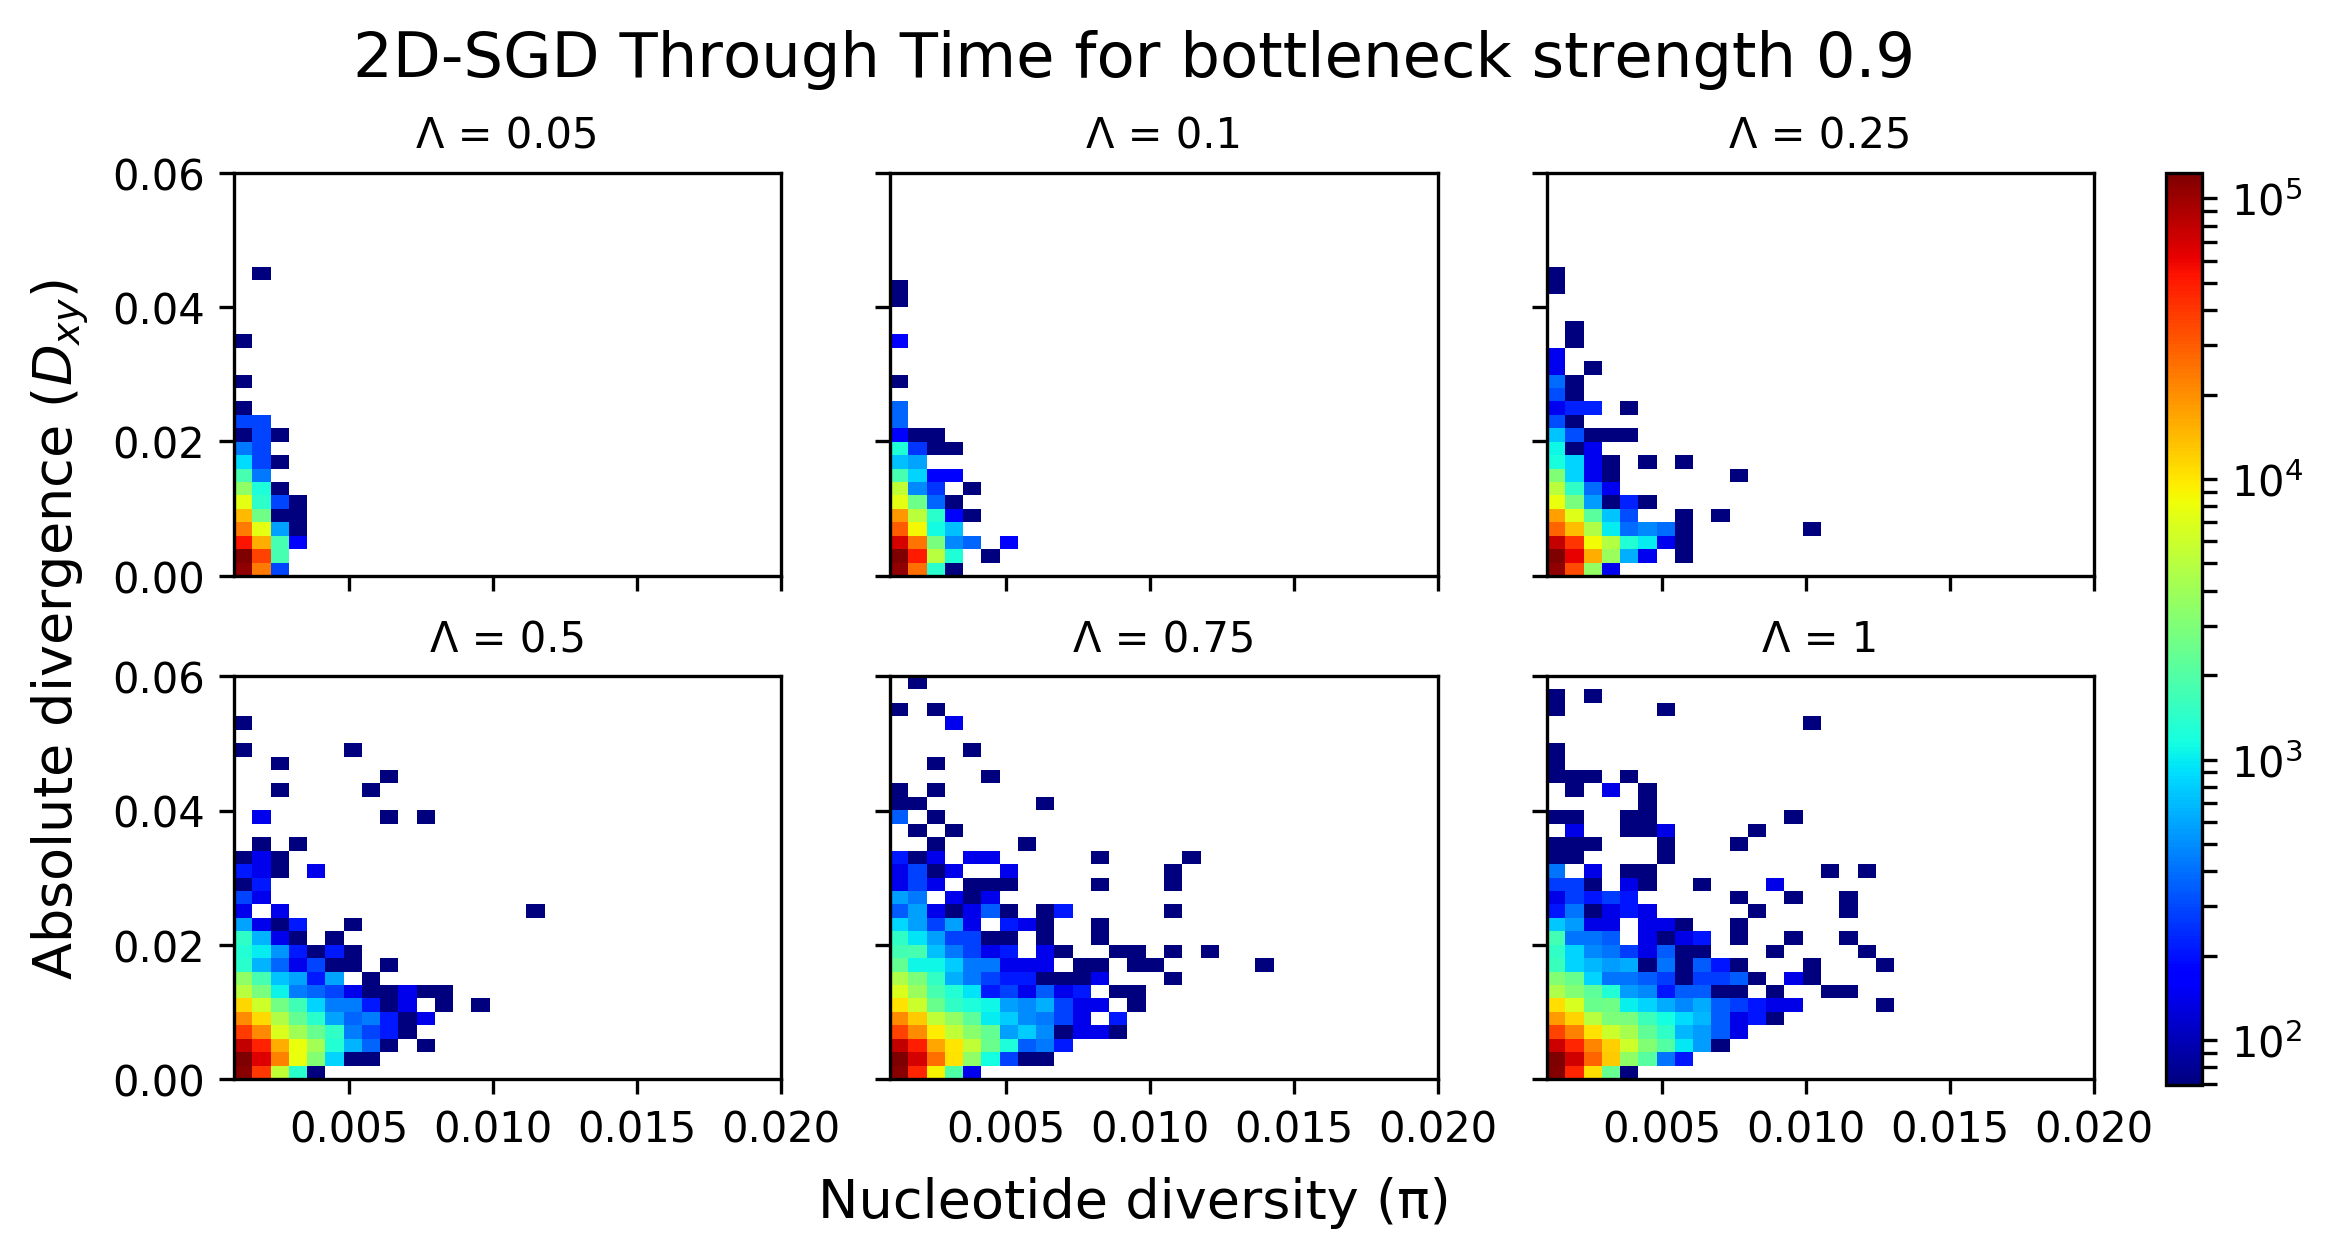

In [21]:
## Uncomment these and comment the below 2 for testing
#for i in [0.5]:
    
for i in bot_strengths:
    plot_2dSGD_per_lambda(pi_dxy_dat[i]["pi"], pi_dxy_dat[i]["dxy"], i)

## Try looking at pi as a function of abundance

In [25]:
## Utility functions
def unpack_abundances(my_abund):
    """ Unpacks packed abundances in my form (tuples), into just raw species abundances """
    raw_abund = []
    for ab in my_abund:
        raw_abund.extend([ab[0]] * ab[1])
    return raw_abund

## quicksort stolen from the internet
def qsort(arr):
     if len(arr) <= 1:
          return arr
     else:
          return qsort([x for x in arr[1:] if x[0]<arr[0][0]])\
                    + [arr[0]] + qsort([x for x in arr[1:] if x[0]>=arr[0][0]])

In [29]:
abund_dat = {}
for bot in bot_strengths:
    ## Get the files
    print("Doing {}".format(bot))
    abundfiles = glob.glob("B-{}*/abundances.txt".format(bot))

    dat = []
    for f in abundfiles:
        lines = open(f).readlines()
        new_lines = []
        for line in lines:
            try:
                ## Parse each line and get rid of bracket characters
                l = line.strip().split()
                d = float(l[0])
                abund = ast.literal_eval(line.split("OrderedDict")[1])
                abund = qsort(abund)
                abund = unpack_abundances(abund)
                new_lines.append([d] + abund)
            except Exception as inst:
                pass
        dat.extend(new_lines)
    print("Processed ntimepoints {}".format(len(dat)))
    abund_dat[bot] = dat

Doing 0.05
Processed ntimepoints 31536
Doing 0.1
Processed ntimepoints 31351
Doing 0.25
Processed ntimepoints 31335
Doing 0.5
Processed ntimepoints 31412
Doing 0.75
Processed ntimepoints 31258
Doing 0.9
Processed ntimepoints 31507


['B-0.9_1515583757.52/abundances.txt', 'B-0.9_1515565871.12/abundances.txt', 'B-0.9_1515557731.15/abundances.txt', 'B-0.9_1515571322.99/abundances.txt', 'B-0.9_1515607185.07/abundances.txt', 'B-0.9_1515601795.79/abundances.txt', 'B-0.9_1515574846.41/abundances.txt', 'B-0.9_1515617615.63/abundances.txt', 'B-0.9_1515596525.97/abundances.txt', 'B-0.9_1515616838.41/abundances.txt', 'B-0.9_1515618438.58/abundances.txt', 'B-0.9_1515590316.88/abundances.txt', 'B-0.9_1515610063.49/abundances.txt', 'B-0.9_1515615040.7/abundances.txt', 'B-0.9_1515578177.45/abundances.txt', 'B-0.9_1515561514.86/abundances.txt', 'B-0.9_1515623501.87/abundances.txt', 'B-0.9_1515600957.91/abundances.txt', 'B-0.9_1515602993.14/abundances.txt', 'B-0.9_1515588638.55/abundances.txt', 'B-0.9_1515620578.47/abundances.txt', 'B-0.9_1515566170.67/abundances.txt', 'B-0.9_1515577656.21/abundances.txt', 'B-0.9_1515582037.28/abundances.txt', 'B-0.9_1515604203.33/abundances.txt', 'B-0.9_1515602429.44/abundances.txt', 'B-0.9_15155